## Import Packages

In [1]:
from spo.data import shortestpath, dataset
from spo.model import shortestPathModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Build Model 

In [4]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [5]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [7]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [8]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [9]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 1000
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.47it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:49<00:00,  2.13it/s]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 227.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:33<00:00,  1.95it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 254.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:25<00:00,  2.24it/s]


Normalized SPO Loss: 0.90%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:07<00:00,  1.82it/s]


Normalized SPO Loss: 4.83%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:19<00:00,  1.79it/s]


Normalized SPO Loss: 0.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:32<00:00,  1.95it/s]


Normalized SPO Loss: 0.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:29<00:00,  1.96it/s]


Normalized SPO Loss: 1.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 320.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:27<00:00,  1.76it/s]


Normalized SPO Loss: 4.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:52<00:00,  1.88it/s]


Normalized SPO Loss: 0.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:28<00:00,  1.59it/s]


Normalized SPO Loss: 0.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [11:27<00:00,  1.45it/s]


Normalized SPO Loss: 1.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 207.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.57it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [11:04<00:00,  1.51it/s]


Normalized SPO Loss: 6.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:13<00:00,  1.81it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 79.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:13<00:00,  1.81it/s]


Normalized SPO Loss: 0.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 281.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:58<00:00,  1.86it/s]


Normalized SPO Loss: 2.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 243.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:14<00:00,  1.80it/s]


Normalized SPO Loss: 6.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 279.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:08<00:00,  1.82it/s]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:05<00:00,  1.83it/s]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


Normalized SPO Loss: 1.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:21<00:00,  1.78it/s]


Normalized SPO Loss: 4.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 192.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [11:21<00:00,  1.47it/s]


Normalized SPO Loss: 0.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 222.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.42it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [12:04<00:00,  1.38it/s]


Normalized SPO Loss: 0.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [11:21<00:00,  1.47it/s]


Normalized SPO Loss: 2.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.96it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:30<00:00,  1.59it/s]


Normalized SPO Loss: 6.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:24<00:00,  1.60it/s]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.31it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:05<00:00,  1.65it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 153.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:17<00:00,  1.62it/s]


Normalized SPO Loss: 1.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 254.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:56<00:00,  1.68it/s]


Normalized SPO Loss: 2.97%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:14<00:00,  1.80it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:16<00:00,  1.80it/s]


Normalized SPO Loss: 0.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 255.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:53<00:00,  1.87it/s]


Normalized SPO Loss: 1.32%

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.50it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:55<00:00,  2.11it/s]


Normalized SPO Loss: 3.45%



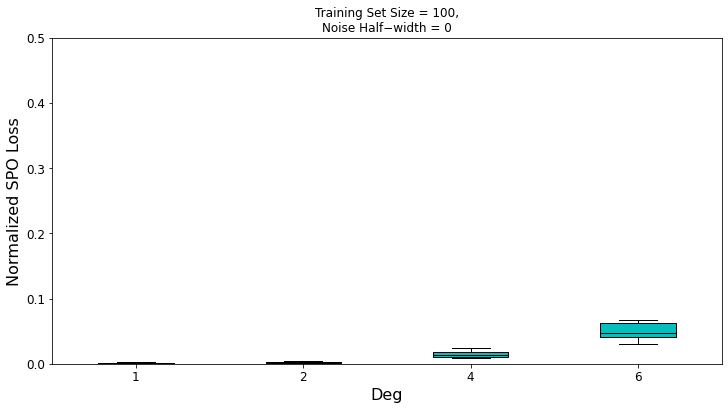

In [10]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [11]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [12]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [13]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 1000
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 212.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:12<00:00,  2.69it/s]


Normalized SPO Loss: 17.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 278.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:42<00:00,  2.48it/s]


Normalized SPO Loss: 11.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:25<00:00,  2.24it/s]


Normalized SPO Loss: 8.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:57<00:00,  2.80it/s]


Normalized SPO Loss: 11.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 281.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:49<00:00,  2.86it/s]


Normalized SPO Loss: 17.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:10<00:00,  2.70it/s]


Normalized SPO Loss: 11.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:50<00:00,  1.88it/s]


Normalized SPO Loss: 7.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [08:30<00:00,  1.96it/s]


Normalized SPO Loss: 8.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:02<00:00,  2.37it/s]


Normalized SPO Loss: 18.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:33<00:00,  2.21it/s]


Normalized SPO Loss: 12.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 161.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:11<00:00,  1.81it/s]


Normalized SPO Loss: 11.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:57<00:00,  1.67it/s]


Normalized SPO Loss: 11.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:01<00:00,  1.66it/s]


Normalized SPO Loss: 19.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 233.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:29<00:00,  1.75it/s]


Normalized SPO Loss: 13.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 102.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:24<00:00,  1.60it/s]


Normalized SPO Loss: 10.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [10:01<00:00,  1.66it/s]


Normalized SPO Loss: 13.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:56<00:00,  1.68it/s]


Normalized SPO Loss: 19.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 108.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:33<00:00,  1.74it/s]


Normalized SPO Loss: 13.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 244.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [09:27<00:00,  1.76it/s]


Normalized SPO Loss: 9.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 279.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.96it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:27<00:00,  2.23it/s]


Normalized SPO Loss: 10.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 301.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:34<00:00,  2.20it/s]


Normalized SPO Loss: 17.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 337.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:09<00:00,  2.33it/s]


Normalized SPO Loss: 12.83%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:10<00:00,  2.32it/s]


Normalized SPO Loss: 10.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [07:32<00:00,  2.21it/s]


Normalized SPO Loss: 15.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 290.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:58<00:00,  2.39it/s]


Normalized SPO Loss: 17.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:57<00:00,  3.36it/s]


Normalized SPO Loss: 12.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 425.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:53<00:00,  3.41it/s]


Normalized SPO Loss: 9.62%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:59<00:00,  3.34it/s]


Normalized SPO Loss: 9.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 388.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:58<00:00,  3.35it/s]


Normalized SPO Loss: 18.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:51<00:00,  3.43it/s]


Normalized SPO Loss: 12.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:54<00:00,  3.39it/s]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s]


Normalized SPO Loss: 11.28%



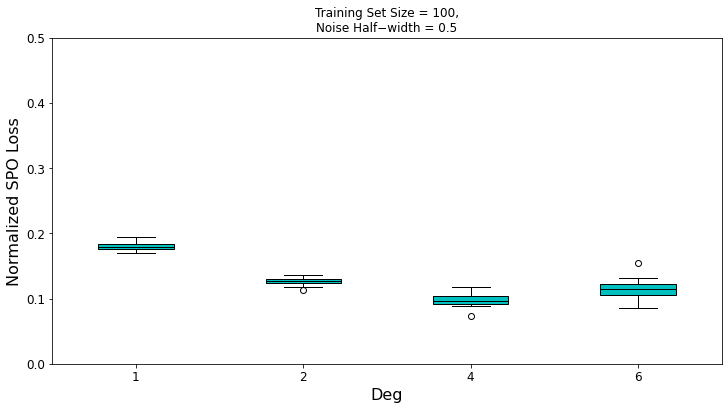

In [14]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [15]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [16]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [17]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.77s/it]


Normalized SPO Loss: 0.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.08s/it]


Normalized SPO Loss: 4.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.71s/it]


Normalized SPO Loss: 0.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.74s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:32<00:00,  2.72s/it]


Normalized SPO Loss: 0.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.73s/it]


Normalized SPO Loss: 3.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.75s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:30<00:00,  2.70s/it]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.79s/it]


Normalized SPO Loss: 1.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:32<00:00,  2.72s/it]


Normalized SPO Loss: 5.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]


Normalized SPO Loss: 0.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.81s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:45<00:00,  2.86s/it]


Normalized SPO Loss: 1.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


Normalized SPO Loss: 5.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 0.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:30<00:00,  2.70s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


Normalized SPO Loss: 1.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:30<00:00,  2.71s/it]


Normalized SPO Loss: 3.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.78s/it]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.71s/it]


Normalized SPO Loss: 1.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.76s/it]


Normalized SPO Loss: 5.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 0.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:42<00:00,  2.83s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:46<00:00,  2.86s/it]


Normalized SPO Loss: 0.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 398.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.78it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.76s/it]


Normalized SPO Loss: 3.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 395.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 397.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.74s/it]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.12it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.73s/it]


Normalized SPO Loss: 0.94%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:29<00:00,  2.69s/it]


Normalized SPO Loss: 4.43%



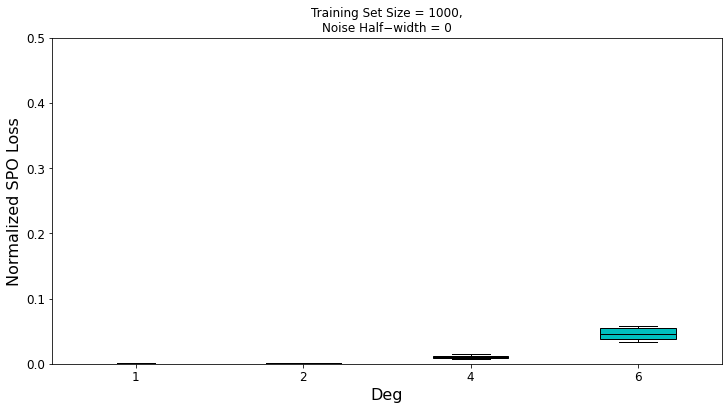

In [18]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [19]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [20]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [21]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


Normalized SPO Loss: 16.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.79s/it]


Normalized SPO Loss: 10.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.43it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


Normalized SPO Loss: 8.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 408.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:29<00:00,  2.70s/it]


Normalized SPO Loss: 11.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:40<00:00,  2.81s/it]


Normalized SPO Loss: 15.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.00s/it]


Normalized SPO Loss: 9.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:01<00:00,  3.01s/it]


Normalized SPO Loss: 6.94%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:20<00:00,  4.41s/it]


Normalized SPO Loss: 8.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [09:20<00:00,  5.60s/it]


Normalized SPO Loss: 16.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [11:35<00:00,  6.96s/it]


Normalized SPO Loss: 12.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [10:09<00:00,  6.10s/it]


Normalized SPO Loss: 9.94%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:25<00:00,  5.06s/it]


Normalized SPO Loss: 12.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:46<00:00,  2.87s/it]


Normalized SPO Loss: 16.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.08it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]


Normalized SPO Loss: 11.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.45s/it]


Normalized SPO Loss: 8.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:30<00:00,  3.31s/it]


Normalized SPO Loss: 11.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/it]


Normalized SPO Loss: 17.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.80s/it]


Normalized SPO Loss: 11.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 9.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:27<00:00,  2.68s/it]


Normalized SPO Loss: 11.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:26<00:00,  2.67s/it]


Normalized SPO Loss: 16.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.78s/it]


Normalized SPO Loss: 11.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 9.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:44<00:00,  2.84s/it]


Normalized SPO Loss: 14.60%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:35<00:00,  2.76s/it]


Normalized SPO Loss: 15.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 394.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]


Normalized SPO Loss: 10.98%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.71s/it]


Normalized SPO Loss: 7.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]


Normalized SPO Loss: 9.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.71s/it]


Normalized SPO Loss: 15.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.58s/it]


Normalized SPO Loss: 9.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:13<00:00,  2.53s/it]


Normalized SPO Loss: 6.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


Normalized SPO Loss: 8.87%



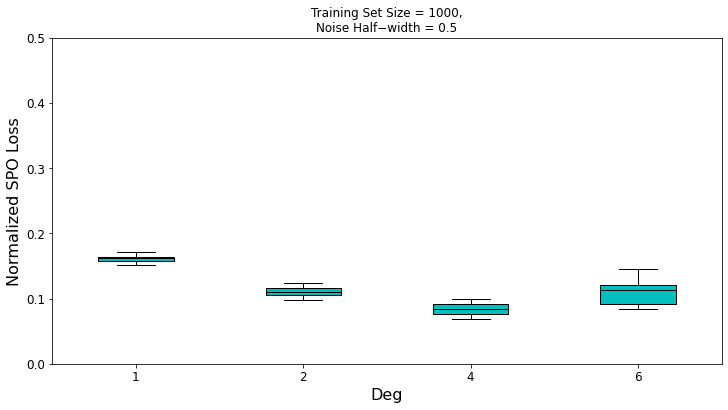

In [22]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [23]:
df1.to_csv('./res/sp/spoplus_n100.csv', index=False)
df2.to_csv('./res/sp/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/sp/spoplus_n1000.csv', index=False)
df4.to_csv('./res/sp/spoplus_n1000_noise.csv', index=False)